In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Colab 폴더로 경로 이동
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning

/content/drive/MyDrive/Colab Notebooks/DeepLearning


# CiFAR 이미지 분류 모델 구현
---
- 데이터: CiFAR10 https://www.cs.toronto.edu/~kriz/cifar.html
- 학습방법: 10가지 이미 종류 분류 => 다중분류
- 이미지: DNN(MLP),CNN적용

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets.cifar10 import load_data

In [ ]:
# W,b 고정하도록 seed 설정
set_random_seed(42)

# [1] 데이터 준비 및 로딩
---

In [ ]:
(x_train, y_train), (x_test,y_test) = load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
print(f'x_train.shape : {x_train.shape}, y_train.shape : {y_train.shape}')
print(f'x_test.shape : {x_test.shape}, y_test.shape : {y_test.shape}')

x_train.shape : (50000, 32, 32, 3), y_train.shape : (50000, 1)
x_test.shape : (10000, 32, 32, 3), y_test.shape : (10000, 1)


# [2] 데이터 전처리 및 학습형태로 변환
---

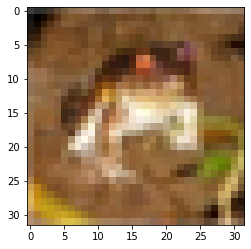

In [ ]:
plt.imshow(x_train[0])
plt.show()

In [ ]:
# 스케일링 => 픽셀 / 255.0
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
# Conv 레이어는 이미지의 채널정보까지 입력해야함 (,,,1)
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

In [ ]:
print(f'x_train.shape : {x_train.shape}')
print(f'x_test.shape : {x_test.shape}')

x_train.shape : (50000, 32, 32, 3)
x_test.shape : (10000, 32, 32, 3)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify= y_train, random_state=42)

In [ ]:
print(f'x_train.shape : {x_train.shape}')
print(f'x_val.shape : {x_val.shape}')
print(f'x_test.shape : {x_test.shape}')

x_train.shape : (37500, 32, 32, 3)
x_val.shape : (12500, 32, 32, 3)
x_test.shape : (10000, 32, 32, 3)


## [3-1] 모델 구상

In [ ]:
model = Sequential()

In [ ]:
# 이미지 특징 추출 Layer => 첫번째 입력값 설정
model.add(Conv2D(32,kernel_size = (3,3), 
                 padding = 'same', 
                 input_shape = (32,32,3),
                 activation = 'relu'))
model.add(Conv2D(32, (3, 3),activation = 'relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),activation = 'relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, (3, 3),activation = 'relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation = 'softmax'))
# 커널 1개, 사이즈 3 -> 3x3 +1(바이어스) => Param =10
# padding 속성 same이 아니면 노드 숫자가 줄어듬.

In [ ]:
# # 이미지 특징 다운샘플링 layer => MaxPool2D
# model.add(MaxPool2D()) #연산은 안하기 때문에 Params = 0

In [ ]:
## 1차원으로 데이터 형태 변환 Layer => Flatten
# model.add(Flatten())

In [ ]:
# # 출력층 => Node : 10개(0~9), activation : softmax
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(10, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

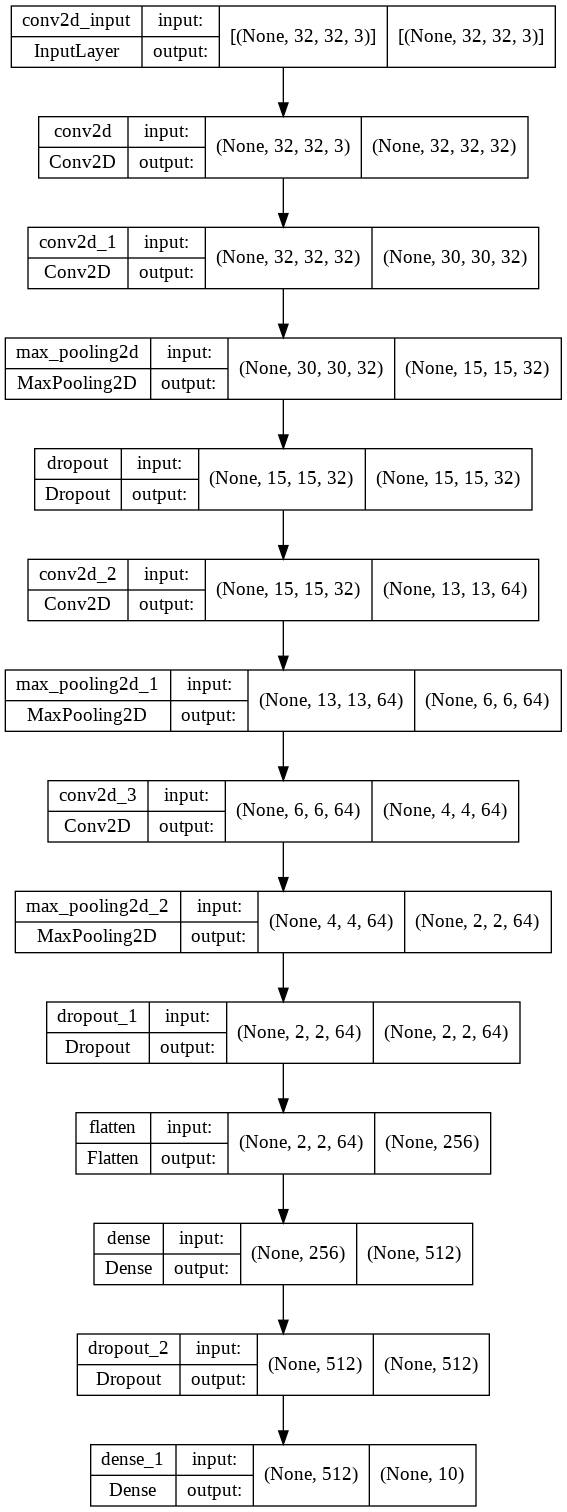

In [ ]:
plot_model(model,show_shapes=True)

## [3-2] 모델 생성
---
- compile메서드
  - loss 손실 함수 => sparse_categorical_crossentropy
  - optimizer 최적화 방식 => adam
  - metrics 평가항목 => accuracy

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'sgd',
              metrics = 'accuracy')

## [3-3] 모델 학습
  - fit메서드
    - 학습 데이터, 라벨
    - epochs 학습횟수
    - batch_size 학습분량
    - validation_data 검증데이터, 검증라벨
    - validation_split 학습데이터의 일부 비율 설정(ex:0.2)
    - callback
    - verbose : 학습 진행도 화면 출력 여부 설정

In [ ]:
# EarlyStopping 생성 (callbacks)
stopCB = EarlyStopping(monitor = 'accuracy', patience = 3)

In [ ]:
his = model.fit(x_train, y_train, 
                epochs = 50, 
                validation_data = (x_val,y_val),
                callbacks=[stopCB])

Epoch 1/100
1172/1172 [==============================] - 21s 7ms/step - loss: 2.2474 - accuracy: 0.1462 - val_loss: 2.0643 - val_accuracy: 0.2218
Epoch 2/100
1172/1172 [==============================] - 7s 6ms/step - loss: 1.9730 - accuracy: 0.2566 - val_loss: 1.8181 - val_accuracy: 0.3314
Epoch 3/100
1172/1172 [==============================] - 7s 6ms/step - loss: 1.8082 - accuracy: 0.3268 - val_loss: 1.8906 - val_accuracy: 0.3377
Epoch 4/100
1172/1172 [==============================] - 8s 7ms/step - loss: 1.6873 - accuracy: 0.3762 - val_loss: 1.5324 - val_accuracy: 0.4462
Epoch 5/100
1172/1172 [==============================] - 8s 7ms/step - loss: 1.5878 - accuracy: 0.4120 - val_loss: 1.5070 - val_accuracy: 0.4594
Epoch 6/100
1172/1172 [==============================] - 8s 6ms/step - loss: 1.5153 - accuracy: 0.4443 - val_loss: 1.4048 - val_accuracy: 0.4958
Epoch 7/100
1172/1172 [==============================] - 7s 6ms/step - loss: 1.4471 - accuracy: 0.4724 - val_loss: 1.3245 - val_a

학습 진행 결과 시각화

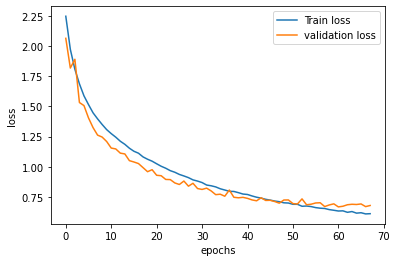

In [ ]:
# loss 비교
plt.plot(his.epoch, his.history['loss'],label='Train loss')
plt.plot(his.epoch, his.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

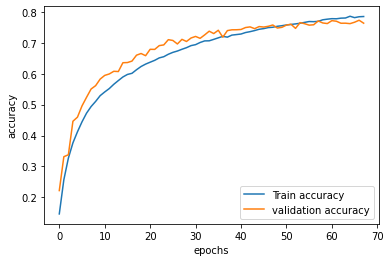

In [ ]:
# accuracy
plt.plot(his.epoch, his.history['accuracy'],label='Train accuracy')
plt.plot(his.epoch, his.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## [4] 평가
---
- evaluate()
- 테스트 데이터, 테스트 라벨

In [ ]:
pre_y = model.predict(x_test)

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6939 - accuracy: 0.7620


[0.6938877701759338, 0.7620000243186951]

# [5] 테스트
---

In [ ]:
# 새로운 사진 예측 함수
from PIL import Image
def pre_print(imagefile):
    pre_val=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

    # 이미지 불러오기
    test_image=Image.open('./'+imagefile).resize((32,32))
    test_image_arr=np.array(test_image)

    # 이미지 그래프로 그리기
    plt.imshow(test_image)
    plt.show()

    # 예측
    result=np.round(model.predict(test_image_arr.reshape(-1,32,32,3)),2)
    print(f"""예측값은 {result}\n
          어떤동물일까요??? {pre_val[result.argmax()]}""")

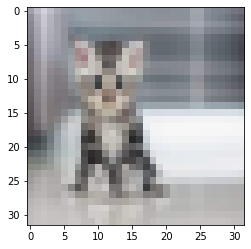

ValueError: ignored

In [ ]:
pre_print('cat2.png')

In [ ]:
test_image=Image.open('./cat2.png').resize((32,32))
test_image_arr=np.array(test_image)

In [ ]:
test_image_arr.shape

(32, 32, 4)